In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Define the repository URL and the local directory where you want to clone/pull the repository
repo_url = 'https://github.com/aakashvardhan/s10-residual-ocp.git'
local_dir = '/content/s10-residual-ocp'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

# !git clone 'https://github.com/aakashvardhan/s10-residual-ocp.git'

/content/s10-residual-ocp
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (5/5), 28.91 KiB | 429.00 KiB/s, done.
From https://github.com/aakashvardhan/s10-residual-ocp
   b97b641..27f95fb  main       -> origin/main
Updating b97b641..27f95fb
Fast-forward
 notebooks/train-ocp-resnet.ipynb | 2 +-
 utils.py                         | 9 +++++----
 2 files changed, 6 insertions(+), 5 deletions(-)


In [3]:
import sys
sys.path.append('/content/s10-residual-ocp')
sys.path.append('/content/s10-residual-ocp/models')

In [4]:
!pip install torch-lr-finder

In [5]:
from config import get_config
config = get_config()
from main import main
import torch
from utils import set_seeds
from setup_cifar10 import setup_cifar10
from torch_lr_finder import LRFinder
from models.custom_resnet import CustomResNet
from models.model_utils import model_summary, adam_optimizer
import torch.nn as nn
set_seeds()

In [6]:
config['epochs'] = 24
config['lr_scheduler'] = 'one_cycle'
config['lr'] = 0.001

CUDA Available? True


100%|██████████| 170498071/170498071 [00:03<00:00, 43165039.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          Identity-2           [-1, 64, 32, 32]               0
          Identity-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
           Dropout-6           [-1, 64, 32, 32]               0
         ConvBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,728
         MaxPool2d-9          [-1, 128, 16, 16]               0
        MaxPool2d-10          [-1, 128, 16, 16]               0
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Drop

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


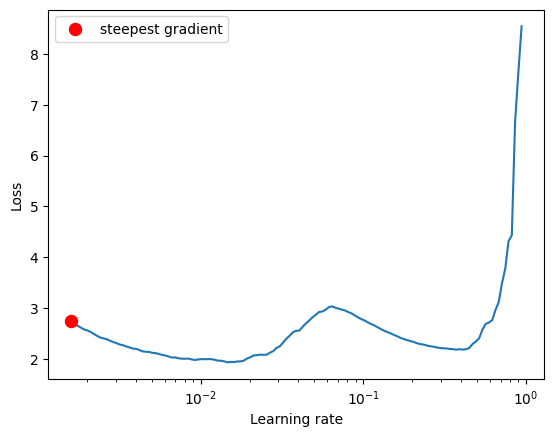

In [7]:
criterion = nn.CrossEntropyLoss()
train_data, test_data, train_loader, test_loader = setup_cifar10(config)
model = CustomResNet(config).to(config["device"])
model_summary(model, input_size=(3, 32, 32))
optimizer = adam_optimizer(model, config)
lr_finder = LRFinder(model, optimizer, criterion, device=config["device"])
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()

In [8]:
config['max_lr'] = 1.59E-03

In [9]:
lr = main(config, model, train_loader, test_loader, optimizer, criterion)

EPOCH: 1


Loss=0.8364895582199097 Batch_id=390 Accuracy=49.54: 100%|██████████| 391/391 [00:20<00:00, 19.06it/s]

Max Learning Rate: 0.0003308811156601843



Test set: Average loss: 0.9516, Accuracy: 6638/10000 (66.38%)

EPOCH: 2


Loss=0.6365810632705688 Batch_id=390 Accuracy=71.55: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s]

Max Learning Rate: 0.0006458622313203685



Test set: Average loss: 0.7709, Accuracy: 7355/10000 (73.55%)

EPOCH: 3


Loss=0.6202318072319031 Batch_id=390 Accuracy=78.91: 100%|██████████| 391/391 [00:21<00:00, 18.26it/s]

Max Learning Rate: 0.0009608433469805528



Test set: Average loss: 0.5709, Accuracy: 8029/10000 (80.29%)

EPOCH: 4


Loss=0.42879796028137207 Batch_id=390 Accuracy=82.44: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s]

Max Learning Rate: 0.001275824462640737



Test set: Average loss: 0.5265, Accuracy: 8216/10000 (82.16%)

EPOCH: 5


Loss=0.43437060713768005 Batch_id=390 Accuracy=84.60: 100%|██████████| 391/391 [00:20<00:00, 18.82it/s]

Max Learning Rate: 0.0015897859952887334



Test set: Average loss: 0.5576, Accuracy: 8183/10000 (81.83%)

EPOCH: 6


Loss=0.4014047086238861 Batch_id=390 Accuracy=86.82: 100%|██████████| 391/391 [00:20<00:00, 18.66it/s]

Max Learning Rate: 0.0015061101531834702



Test set: Average loss: 0.5273, Accuracy: 8317/10000 (83.17%)

EPOCH: 7


Loss=0.1348096877336502 Batch_id=390 Accuracy=89.36: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s]

Max Learning Rate: 0.001422434311078207



Test set: Average loss: 0.4132, Accuracy: 8570/10000 (85.70%)

EPOCH: 8


Loss=0.4353017807006836 Batch_id=390 Accuracy=90.82: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s]

Max Learning Rate: 0.001338758468972944



Test set: Average loss: 0.5614, Accuracy: 8366/10000 (83.66%)

EPOCH: 9


Loss=0.3787405490875244 Batch_id=390 Accuracy=92.01: 100%|██████████| 391/391 [00:20<00:00, 18.84it/s]

Max Learning Rate: 0.0012550826268676808



Test set: Average loss: 0.5013, Accuracy: 8449/10000 (84.49%)

EPOCH: 10


Loss=0.1681176722049713 Batch_id=390 Accuracy=93.16: 100%|██████████| 391/391 [00:20<00:00, 18.63it/s]

Max Learning Rate: 0.0011714067847624176



Test set: Average loss: 0.4009, Accuracy: 8727/10000 (87.27%)

EPOCH: 11


Loss=0.25556010007858276 Batch_id=390 Accuracy=93.87: 100%|██████████| 391/391 [00:21<00:00, 18.58it/s]

Max Learning Rate: 0.0010877309426571545



Test set: Average loss: 0.4378, Accuracy: 8665/10000 (86.65%)

EPOCH: 12


Loss=0.045020438730716705 Batch_id=390 Accuracy=94.93: 100%|██████████| 391/391 [00:21<00:00, 18.53it/s]

Max Learning Rate: 0.0010040551005518913



Test set: Average loss: 0.4256, Accuracy: 8757/10000 (87.57%)

EPOCH: 13


Loss=0.10255012661218643 Batch_id=390 Accuracy=95.25: 100%|██████████| 391/391 [00:20<00:00, 18.64it/s]

Max Learning Rate: 0.0009203792584466281



Test set: Average loss: 0.3753, Accuracy: 8853/10000 (88.53%)

EPOCH: 14


Loss=0.1360274851322174 Batch_id=390 Accuracy=95.85: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s]

Max Learning Rate: 0.000836703416341365



Test set: Average loss: 0.3834, Accuracy: 8891/10000 (88.91%)

EPOCH: 15


Loss=0.10438273102045059 Batch_id=390 Accuracy=96.36: 100%|██████████| 391/391 [00:21<00:00, 18.45it/s]

Max Learning Rate: 0.0007530275742361018



Test set: Average loss: 0.4132, Accuracy: 8813/10000 (88.13%)

EPOCH: 16


Loss=0.12863044440746307 Batch_id=390 Accuracy=96.85: 100%|██████████| 391/391 [00:20<00:00, 18.75it/s]

Max Learning Rate: 0.0006693517321308386



Test set: Average loss: 0.3861, Accuracy: 8867/10000 (88.67%)

EPOCH: 17


Loss=0.07679285109043121 Batch_id=390 Accuracy=97.36: 100%|██████████| 391/391 [00:20<00:00, 18.92it/s]

Max Learning Rate: 0.0005856758900255755



Test set: Average loss: 0.3330, Accuracy: 9022/10000 (90.22%)

EPOCH: 18


Loss=0.08150152862071991 Batch_id=390 Accuracy=97.68: 100%|██████████| 391/391 [00:21<00:00, 18.57it/s]

Max Learning Rate: 0.0005020000479203123



Test set: Average loss: 0.3678, Accuracy: 8994/10000 (89.94%)

EPOCH: 19


Loss=0.10088424384593964 Batch_id=390 Accuracy=98.46: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s]

Max Learning Rate: 0.0004183242058150491



Test set: Average loss: 0.3532, Accuracy: 9011/10000 (90.11%)

EPOCH: 20


Loss=0.06500645726919174 Batch_id=390 Accuracy=98.86: 100%|██████████| 391/391 [00:20<00:00, 18.85it/s]

Max Learning Rate: 0.0003346483637097859



Test set: Average loss: 0.3362, Accuracy: 9080/10000 (90.80%)

EPOCH: 21


Loss=0.021976685151457787 Batch_id=390 Accuracy=99.19: 100%|██████████| 391/391 [00:20<00:00, 18.74it/s]

Max Learning Rate: 0.00025097252160452294



Test set: Average loss: 0.3318, Accuracy: 9083/10000 (90.83%)

EPOCH: 22


Loss=0.04038158804178238 Batch_id=390 Accuracy=99.46: 100%|██████████| 391/391 [00:21<00:00, 18.54it/s]

Max Learning Rate: 0.00016729667949925953



Test set: Average loss: 0.3211, Accuracy: 9142/10000 (91.42%)

EPOCH: 23


Loss=0.010909037664532661 Batch_id=390 Accuracy=99.62: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s]

Max Learning Rate: 8.362083739399655e-05



Test set: Average loss: 0.3103, Accuracy: 9178/10000 (91.78%)

EPOCH: 24


Loss=0.0029633468948304653 Batch_id=390 Accuracy=99.73: 100%|██████████| 391/391 [00:21<00:00, 18.58it/s]

Max Learning Rate: -5.5004711266423353e-08



Test set: Average loss: 0.3052, Accuracy: 9198/10000 (91.98%)



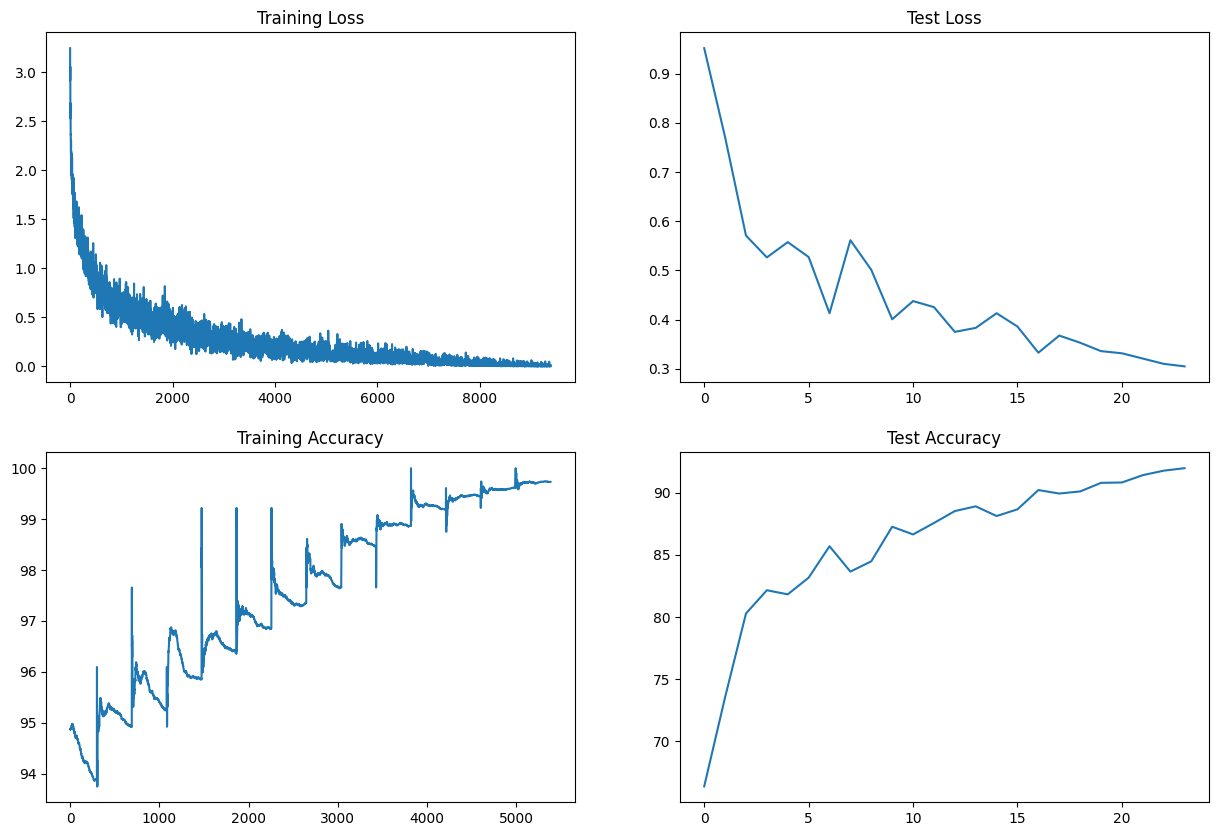

In [10]:
import matplotlib.pyplot as plt
from utils import plt_fig
plt_fig()

In [11]:
from visualize import show_misclassified_images, plt_misclassified_images

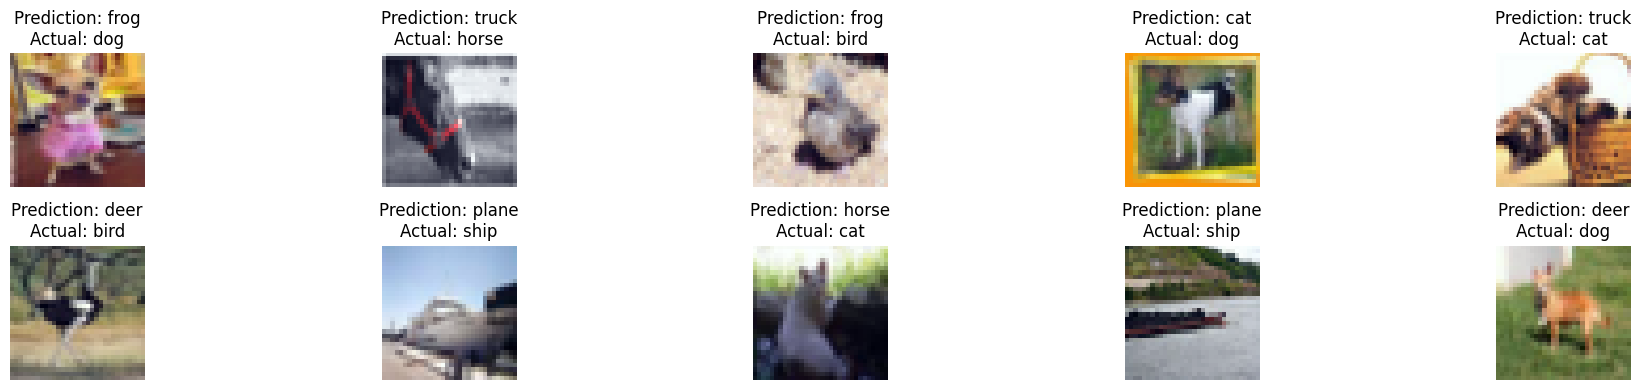

In [12]:
misclass_imgs, misclass_targets, misclass_preds = show_misclassified_images(model, test_loader, config)
plt_misclassified_images(config, misclass_imgs, misclass_targets, misclass_preds)